In [208]:
import re
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from scipy import stats

# ---------------------------
# Parsing
# ---------------------------

def parse_results_file(path: str) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Parse one results file.

    Returns:
      data[model][metric] = {'value': float, 'lo': float or None, 'hi': float or None}
    Skips entries with "Not found".
    """
    data: Dict[str, Dict[str, Dict[str, float]]] = {}
    current_model = None

    if ('_sc_' in path and not '_vs_' in path):
        if "_all" in path:
            subject_re = re.compile(r'^--- Analyzing (.+?) \(') 
        else:  
            subject_re = re.compile(r'^--- Analyzing (.+?) \(Redacted, Incorrect') 
    else:
        subject_re = re.compile(r'^\s*Subject:\s*(.+?)\s*$')

    line_re = re.compile(r'^\s*(.+?)[=:]\s*(.+?)\s*$')
    num_ci_re = re.compile(
        r'^\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*\[\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*,\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*\]'
    )
    num_only_re = re.compile(r'^\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*$')

    with open(path, 'r', encoding='utf-8') as f:
        for raw in f:
            line = raw.rstrip('\n')

            m_sub = subject_re.match(line)
            if m_sub:
                current_model = m_sub.group(1).strip()
                if current_model not in data:
                    data[current_model] = {}
                continue

            m_line = line_re.match(line)
            if not m_line or current_model is None:
                continue

            metric = m_line.group(1).strip()
            val_str = m_line.group(2).strip()

            # Skip "Not found"
            if val_str.lower().startswith('not found'):
                continue

            m_num_ci = num_ci_re.match(val_str)
            if m_num_ci:
                v = float(m_num_ci.group(1))
                lo = float(m_num_ci.group(2))
                hi = float(m_num_ci.group(3))
                if metric not in data[current_model]:
                    data[current_model][metric] = {'value': v, 'lo': lo, 'hi': hi}
                continue

            m_num = num_only_re.match(val_str)
            if m_num:
                v = float(m_num.group(1))
                if metric not in data[current_model]:
                    data[current_model][metric] = {'value': v, 'lo': None, 'hi': None}
                continue

            # Unrecognized format; ignore
    return data


# ---------------------------
# Utilities
# ---------------------------

def is_correlation_metric(metric_name: str) -> bool:
    """Heuristic: treat metrics containing 'correl' (case-insensitive) as correlations."""
    return 'correl' in metric_name.lower()

def zcrit_from_level(level: float = 0.95) -> float:
    return stats.norm.ppf(0.5 + level/2.0)

def fisher_z(x: np.ndarray) -> np.ndarray:
    x = np.clip(x, -0.999999, 0.999999)
    return np.arctanh(x)

def inv_fisher_z(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)

def se_from_ci(lo: np.ndarray, hi: np.ndarray, level: float = 0.95) -> np.ndarray:
    zcrit = zcrit_from_level(level)
    return (hi - lo) / (2.0 * zcrit)

def se_from_ci_fisher_r(lo_r: np.ndarray, hi_r: np.ndarray, level: float = 0.95) -> np.ndarray:
    zcrit = zcrit_from_level(level)
    lo_z = fisher_z(lo_r)
    hi_z = fisher_z(hi_r)
    return (hi_z - lo_z) / (2.0 * zcrit)

def fixed_effect_pool(values: np.ndarray, se: np.ndarray) -> Tuple[float, float, float]:
    """Inverse-variance weighted mean and its SE and CI bounds (on the same scale as values)."""
    w = 1.0 / (se**2)
    mu = np.sum(w * values) / np.sum(w)
    se_mu = 1.0 / np.sqrt(np.sum(w))
    return mu, se_mu, w.sum()

def mean_t_ci(x: np.ndarray, level: float = 0.95) -> Tuple[float, float, float]:
    """Mean, SE, and t critical for a sample (across models)."""
    k = x.size
    m = x.mean()
    sd = x.std(ddof=1) if k > 1 else 0.0
    se = sd / np.sqrt(k) if k > 0 else np.nan
    tcrit = stats.t.ppf(0.5 + level/2.0, df=max(k-1, 1))
    return m, se, tcrit


# ---------------------------
# Collect per-metric data
# ---------------------------

def collect_metric_data(metric: str, file_paths: List[str]) -> Dict[str, pd.DataFrame]:
    """
    For each file, return a DataFrame with columns:
      model, value, lo, hi, has_ci (bool)
    Only includes models that have the metric present.
    """
    out = {}
    metric_lower = metric.lower()
    for path in file_paths:
        parsed = parse_results_file(path)
        rows = []
        for model, metrics in parsed.items():
            # case-insensitive lookup across keys
            match_key = None
            for k in metrics.keys():
                if k.lower() == metric_lower:
                    match_key = k
                    break
            if match_key is None:
                continue
            entry = metrics[match_key]
            v = entry.get('value', None)
            lo = entry.get('lo', None)
            hi = entry.get('hi', None)
            if v is None:
                continue
            has_ci = lo is not None and hi is not None
            rows.append({'model': model, 'value': float(v),
                         'lo': float(lo) if has_ci else np.nan,
                         'hi': float(hi) if has_ci else np.nan,
                         'has_ci': has_ci})
        df = pd.DataFrame(rows)
        out[path] = df.sort_values('model').reset_index(drop=True)
    return out


# ---------------------------
# Per-file summaries
# ---------------------------

def summarize_per_file(metric: str,
                       file_to_df: Dict[str, pd.DataFrame],
                       ci_level: float = 0.95) -> pd.DataFrame:
    """
    For each file, compute an overall mean and CI:
      - If per-model CIs exist: fixed-effect inverse-variance pooling.
        * If correlation metric: operate on Fisher z and back-transform for reporting.
        * Else: operate on raw scale.
      - If no per-model CIs: mean±t across models.
    Returns a DataFrame with columns:
      file, n_models, method, mean, ci_lo, ci_hi
    """
    is_corr = is_correlation_metric(metric)
    zcrit = zcrit_from_level(ci_level)

    rows = []
    for path, df in file_to_df.items():
        n = len(df)
        if n == 0:
            rows.append({'file': path, 'n_models': 0, 'method': 'no data',
                         'mean': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan})
            continue

        has_any_ci = df['has_ci'].any()
        if has_any_ci:
            # Use only models with CIs
            d = df[df['has_ci']].copy()
            if len(d) == 0:
                rows.append({'file': path, 'n_models': 0, 'method': 'no usable CI',
                             'mean': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan})
                continue

            if is_corr:
                # Pool on Fisher z
                vals_z = fisher_z(d['value'].to_numpy())
                se_z = se_from_ci_fisher_r(d['lo'].to_numpy(), d['hi'].to_numpy(), level=ci_level)
                se_z, used_floor = stabilize_se(se_z, fallback='floor')
                z_bar, se_bar, _ = fixed_effect_pool(vals_z, se_z)
                ci_z = (z_bar - zcrit*se_bar, z_bar + zcrit*se_bar)
                mean_r = float(inv_fisher_z(np.array([z_bar]))[0])
                ci_lo = float(inv_fisher_z(np.array([ci_z[0]]))[0])
                ci_hi = float(inv_fisher_z(np.array([ci_z[1]]))[0])
                method = 'fixed-effect IVW on Fisher z'
                rows.append({'file': path, 'n_models': int(len(d)), 'method': method,
                             'mean': mean_r, 'ci_lo': ci_lo, 'ci_hi': ci_hi})
            else:
                # Pool on raw scale
                vals = d['value'].to_numpy()
                se = se_from_ci(d['lo'].to_numpy(), d['hi'].to_numpy(), level=ci_level)
                se, used_floor = stabilize_se(se, fallback='floor')
                mu, se_mu, _ = fixed_effect_pool(vals, se)
                ci = (mu - zcrit*se_mu, mu + zcrit*se_mu)
                method = 'fixed-effect IVW (raw scale)'
                rows.append({'file': path, 'n_models': int(len(d)), 'method': method,
                             'mean': float(mu), 'ci_lo': float(ci[0]), 'ci_hi': float(ci[1])})
        else:
            # No per-model CIs -> mean±t across models
            vals = df['value'].to_numpy()
            m, se, tcrit = mean_t_ci(vals, level=ci_level)
            ci = (m - tcrit*se, m + tcrit*se) if len(vals) > 1 else (m, m)
            method = 'mean±t across models (no model CIs)'
            rows.append({'file': path, 'n_models': int(len(vals)), 'method': method,
                         'mean': float(m), 'ci_lo': float(ci[0]), 'ci_hi': float(ci[1])})

    summary = pd.DataFrame(rows)
    return summary


# ---------------------------
# Pairwise comparisons
# ---------------------------

def pairwise_comparisons(metric: str,
                         file_to_df: Dict[str, pd.DataFrame],
                         ci_level: float = 0.95,
                         assume_independent: bool = True) -> pd.DataFrame:
    """
    For each file pair:
      - Identify overlapping models with data for the metric in both.
      - If both sides have per-model CIs for the overlaps:
          * If correlation metric: paired IVW difference on Fisher z.
          * Else: paired IVW difference on raw scale.
      - Else (no CIs): paired t-test across models (raw differences).

    Returns DataFrame with:
      file1, file2, n_common, same_model_set, method, est, ci_lo, ci_hi, p_value
    est/CI are on:
      - Fisher z scale for correlation metrics (paired IVW),
      - raw scale otherwise,
      - raw scale difference for paired t.
    """
    is_corr = is_correlation_metric(metric)
    zcrit = zcrit_from_level(ci_level)
    files = list(file_to_df.keys())

    # Precompute model sets for equality check
    models_per_file = {f: set(file_to_df[f]['model']) for f in files}

    records = []

    for i in range(len(files)):
        for j in range(i+1, len(files)):
            f1, f2 = files[i], files[j]
            d1 = file_to_df[f1]
            d2 = file_to_df[f2]
            overlap = sorted(set(d1['model']).intersection(set(d2['model'])))

            same_set = models_per_file[f1] == models_per_file[f2]
            if len(overlap) == 0:
                records.append({'file1': f1, 'file2': f2, 'n_common': 0, 'same_model_set': same_set,
                                'method': 'no overlap', 'est': np.nan, 'ci_lo': np.nan,
                                'ci_hi': np.nan, 'p_value': np.nan})
                continue

            # Join on model
            j1 = d1.set_index('model').loc[overlap]
            j2 = d2.set_index('model').loc[overlap]

            # Identify if we can do IVW (need CIs on both)
            use_ivw = j1['has_ci'].all() and j2['has_ci'].all()

            if use_ivw:
                if is_corr:
                    # Work on Fisher z
                    v1 = fisher_z(j1['value'].to_numpy())
                    v2 = fisher_z(j2['value'].to_numpy())
                    se1 = se_from_ci_fisher_r(j1['lo'].to_numpy(), j1['hi'].to_numpy(), level=ci_level)
                    se2 = se_from_ci_fisher_r(j2['lo'].to_numpy(), j2['hi'].to_numpy(), level=ci_level)
                    # Independence assumption -> Var(d) = se1^2 + se2^2
                    var_d = se1**2 + se2**2 if assume_independent else se1**2 + se2**2
                    d = v2 - v1
                    w = 1.0 / var_d
                    D = np.sum(w * d) / np.sum(w)
                    SE_D = 1.0 / np.sqrt(np.sum(w))
                    ci = (D - zcrit*SE_D, D + zcrit*SE_D)
                    z_stat = D / SE_D
                    p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
                    method = 'paired IVW on Fisher z'
                    records.append({'file1': f1, 'file2': f2, 'n_common': len(overlap),
                                    'same_model_set': same_set, 'method': method,
                                    'est': float(D), 'ci_lo': float(ci[0]),
                                    'ci_hi': float(ci[1]), 'p_value': float(p)})
                else:
                    # Raw scale IVW
                    v1 = j1['value'].to_numpy()
                    v2 = j2['value'].to_numpy()
                    se1 = se_from_ci(j1['lo'].to_numpy(), j1['hi'].to_numpy(), level=ci_level)
                    se2 = se_from_ci(j2['lo'].to_numpy(), j2['hi'].to_numpy(), level=ci_level)
                    var_d = se1**2 + se2**2 if assume_independent else se1**2 + se2**2
                    d = v2 - v1
                    w = 1.0 / var_d
                    D = np.sum(w * d) / np.sum(w)
                    SE_D = 1.0 / np.sqrt(np.sum(w))
                    ci = (D - zcrit*SE_D, D + zcrit*SE_D)
                    z_stat = D / SE_D
                    p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
                    method = 'paired IVW (raw scale)'
                    records.append({'file1': f1, 'file2': f2, 'n_common': len(overlap),
                                    'same_model_set': same_set, 'method': method,
                                    'est': float(D), 'ci_lo': float(ci[0]),
                                    'ci_hi': float(ci[1]), 'p_value': float(p)})
            else:
                # Paired t on raw differences across models
                # Use only models with values (ignore CI fields)
                v1 = j1['value'].to_numpy()
                v2 = j2['value'].to_numpy()
                d = v2 - v1
                k = d.size
                Dbar = d.mean()
                sd = d.std(ddof=1) if k > 1 else 0.0
                se = sd / np.sqrt(k) if k > 0 else np.nan
                tcrit = stats.t.ppf(0.5 + ci_level/2.0, df=max(k-1, 1))
                ci = (Dbar - tcrit*se, Dbar + tcrit*se) if k > 1 else (Dbar, Dbar)
                t_stat = Dbar / se if se > 0 else np.inf * np.sign(Dbar)
                p = 2.0 * (1.0 - stats.t.cdf(abs(t_stat), df=max(k-1, 1))) if k > 1 else 0.0
                method = 'paired t across models (no model CIs)'
                records.append({'file1': f1, 'file2': f2, 'n_common': int(k),
                                'same_model_set': same_set, 'method': method,
                                'est': float(Dbar), 'ci_lo': float(ci[0]),
                                'ci_hi': float(ci[1]), 'p_value': float(p)})

    return pd.DataFrame.from_records(records)


# ---------------------------
# Main entry point
# ---------------------------

def analyze_metric_across_files(metric_name: str,
                                file_paths: List[str],
                                ci_level: float = 0.95,
                                assume_independent: bool = True):
    """
    High-level function:
      - Parses files
      - Builds per-file summaries
      - Builds pairwise comparison table

    Returns (summary_df, pairwise_df)
    Also prints both tables.
    """
    file_to_df = collect_metric_data(metric_name, file_paths)

    # Per-file summaries
    summary = summarize_per_file(metric_name, file_to_df, ci_level=ci_level)

    # Pairwise comparisons
    pairwise = pairwise_comparisons(metric_name, file_to_df,
                                    ci_level=ci_level,
                                    assume_independent=assume_independent)

    # Pretty print
    pd.set_option('display.max_colwidth', 120)
    print(f"\nMetric: {metric_name}")
    print("\nPer-file summaries:")
    display(summary)

    print("\nPairwise comparisons:")
    display(pairwise)

    return summary, pairwise

def difference_of_pooled_test(summary_df: pd.DataFrame, ci_level: float = 0.95) -> pd.DataFrame:
    """
    For each file pair in a summary table (from summarize_per_file), test the
    difference between pooled means using their pooled SEs.

    Returns: file1, file2, est, ci_lo, ci_hi, p_value
    """
    zcrit = zcrit_from_level(ci_level)
    rows = []
    for i in range(len(summary_df)):
        for j in range(i+1, len(summary_df)):
            a = summary_df.iloc[i]
            b = summary_df.iloc[j]
            m1, m2 = float(a['mean']), float(b['mean'])
            se1 = (float(a['ci_hi']) - m1) / zcrit
            se2 = (float(b['ci_hi']) - m2) / zcrit
            diff = m1 - m2
            se = np.sqrt(se1**2 + se2**2)
            ci = (diff - zcrit*se, diff + zcrit*se)
            z_stat = diff / se if se > 0 else np.inf * np.sign(diff)
            p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
            rows.append({'file1': a['file'], 'file2': b['file'],
                         'est': diff, 'ci_lo': ci[0], 'ci_hi': ci[1], 'p_value': p})
    return pd.DataFrame(rows)

def stabilize_se(se: np.ndarray, fallback: str = 'floor') -> Tuple[np.ndarray, bool]:
    """
    Replace nonpositive or nonfinite SEs.
    fallback:
      - 'floor': set to 0.5 * min positive SE (or 1e-12 if none).
      - 'drop': return SEs and a flag indicating there were bad SEs (caller can drop rows).
    Returns (se_fixed, used_floor)
    """
    se = np.asarray(se, float)
    pos = np.isfinite(se) & (se > 0)
    if pos.any():
        floor = max(1e-12, 0.5 * float(np.min(se[pos])))
        bad = ~pos
        if fallback == 'floor':
            se[bad] = floor
            return se, True if bad.any() else False
        elif fallback == 'drop':
            return se, bad.any()
    else:
        # No positive SEs at all
        if fallback == 'floor':
            se[:] = 1e-12
            return se, True
        elif fallback == 'drop':
            return se, True
    return se, False


def pool_metric_ivw(metric: str, files: List[str], ci_level: float = 0.95) -> Dict[str, Dict[str, float]]:
    # Returns: {model: {'value': pooled_mean, 'lo': ci_lo, 'hi': ci_hi}}
    try:
        from scipy.stats import norm
        z = float(norm.ppf(0.5 + ci_level/2.0))
    except Exception:
        z = 1.96 if abs(ci_level - 0.95) < 1e-6 else 1.96  # basic fallback

    parsed = [parse_results_file(f) for f in files]
    all_models = sorted(set().union(*[set(d.keys()) for d in parsed]))
    out: Dict[str, Dict[str, float]] = {}

    for m in all_models:
        means, ses = [], []
        for d in parsed:
            entry = d.get(m, {}).get(metric) or next((d.get(m, {}).get(k) for k in d.get(m, {}) if k.lower()==metric.lower()), None)
            if not entry:
                continue
            mu = entry.get("value")
            lo = entry.get("lo")
            hi = entry.get("hi")
            if mu is None or not np.isfinite([mu]).all():
                continue
            if lo is None or hi is None:
                #compute SE of proportions, using N=447
                se = math.sqrt(mu * (1.0 - mu) / 447)
            else:
                se = (hi - lo) / (2.0 * z)
            if se <= 0 or not np.isfinite(se):
                continue
            means.append(mu)
            ses.append(se)

        if len(means) == 0:
            continue

        w = np.reciprocal(np.square(ses))
        mu_hat = float(np.sum(w * means) / np.sum(w))
        se_mu = float(math.sqrt(1.0 / np.sum(w)))
        lo_hat = mu_hat - z * se_mu
        hi_hat = mu_hat + z * se_mu
        out[m] = {"value": mu_hat, "lo": lo_hat, "hi": hi_hat}

    return out

from typing import List, Dict
import numpy as np
import pandas as pd

def _pool_group_dfs_for_metric(dfs: List[pd.DataFrame],
                               metric_name: str,
                               ci_level: float = 0.95) -> pd.DataFrame:
    """
    Pool a list of per-file DataFrames (for one metric) into a single per-model
    DataFrame via fixed-effects IVW.

    Inputs are the DataFrames produced by collect_metric_data (columns:
      'model','value','lo','hi','has_ci').

    Returns a DataFrame with columns:
      'model','value','lo','hi','has_ci' (has_ci=True for pooled rows).
    """
    if not dfs:
        return pd.DataFrame(columns=['model','value','lo','hi','has_ci'])

    is_corr = is_correlation_metric(metric_name)
    zcrit = zcrit_from_level(ci_level)

    # Gather per-model observations across files
    by_model: Dict[str, Dict[str, list]] = {}
    for df in dfs:
        if df is None or len(df) == 0:
            continue
        for _, row in df.iterrows():
            m = row['model']
            if not row.get('has_ci', False):
                continue  # need CI to derive SE for pooling
            mu = float(row['value'])
            lo = float(row['lo'])
            hi = float(row['hi'])
            if m not in by_model:
                by_model[m] = {'mu': [], 'se': []}

            if is_corr:
                # Pool on Fisher z; derive SE on z-scale
                se = se_from_ci_fisher_r(np.array([lo]), np.array([hi]), level=ci_level)[0]
                by_model[m]['mu'].append(float(fisher_z(np.array([mu]))[0]))
                by_model[m]['se'].append(float(se))
            else:
                # Pool on raw scale
                se = se_from_ci(np.array([lo]), np.array([hi]), level=ci_level)[0]
                by_model[m]['mu'].append(mu)
                by_model[m]['se'].append(float(se))

    # Build pooled rows
    rows = []
    for m, agg in by_model.items():
        mus = np.asarray(agg['mu'], float)
        ses = np.asarray(agg['se'], float)
        if mus.size == 0:
            continue
        ses, _ = stabilize_se(ses, fallback='floor')
        mu_hat, se_mu, _ = fixed_effect_pool(mus, ses)
        if is_corr:
            # back-transform to r, and CI via z-scale then back
            lo_hat_z = mu_hat - zcrit * se_mu
            hi_hat_z = mu_hat + zcrit * se_mu
            val = float(inv_fisher_z(np.array([mu_hat]))[0])
            lo_r = float(inv_fisher_z(np.array([lo_hat_z]))[0])
            hi_r = float(inv_fisher_z(np.array([hi_hat_z]))[0])
            rows.append({'model': m, 'value': val, 'lo': lo_r, 'hi': hi_r, 'has_ci': True})
        else:
            lo_hat = mu_hat - zcrit * se_mu
            hi_hat = mu_hat + zcrit * se_mu
            rows.append({'model': m, 'value': float(mu_hat), 'lo': float(lo_hat), 'hi': float(hi_hat), 'has_ci': True})

    pooled_df = pd.DataFrame(rows, columns=['model','value','lo','hi','has_ci']).sort_values('model').reset_index(drop=True)
    return pooled_df

def analyze_metric_across_file_groups(metric_name: str,
                                      file_paths_a: List[str],
                                      file_paths_b: List[str],
                                      label_a: str = "Group A",
                                      label_b: str = "Group B",
                                      ci_level: float = 0.95,
                                      assume_independent: bool = True):
    """
    Combine each group of files first (per-model IVW), then run the same
    summarize + pairwise comparisons as analyze_metric_across_files.
    """
    # Parse to per-file DataFrames using your existing helper
    file_to_df_a = collect_metric_data(metric_name, file_paths_a)
    file_to_df_b = collect_metric_data(metric_name, file_paths_b)

    # Pool within group (per model)
    pooled_a_df = _pool_group_dfs_for_metric(list(file_to_df_a.values()), metric_name, ci_level=ci_level)
    pooled_b_df = _pool_group_dfs_for_metric(list(file_to_df_b.values()), metric_name, ci_level=ci_level)

    # Feed pooled “files” into the existing pipeline
    file_to_df = {
        label_a: pooled_a_df,
        label_b: pooled_b_df,
    }

    summary = summarize_per_file(metric_name, file_to_df, ci_level=ci_level)
    pairwise = pairwise_comparisons(metric_name, file_to_df, ci_level=ci_level, assume_independent=assume_independent)

    pd.set_option('display.max_colwidth', 120)
    print(f"\nMetric: {metric_name}")
    print("\nPer-file summaries:")
    display(summary)
    print("\nPairwise comparisons:")
    display(pairwise)

    return summary, pairwise


In [221]:
metric = "Normalized lift"

if metric in ["Mean capabilities_entropy-game_entropy", "Proportion of changes to 2nd choice"]:
    files = ["analysis_log_multi_logres_sc_gpqa_new_all.txt", "analysis_log_multi_logres_sc_simplemc_new_all.txt", "analysis_log_multi_logres_sc_gpsa_new_all.txt", "analysis_log_multi_logres_sc_simpleqa_new_all.txt"]
    #files = ["analysis_log_multi_logres_sc_gpqa_neut_all.txt", "analysis_log_multi_logres_sc_simplemc_neut_all.txt", "analysis_log_multi_logres_sc_gpsa_neut_all.txt", "analysis_log_multi_logres_sc_simpleqa_neut_all.txt"]
elif metric == "Normalized lift": files = ["analysis_log_multi_logres_sc_gpqa_new_all_vs_neutral_parsed.txt", "analysis_log_multi_logres_sc_simplemc_new_all_vs_neutral_parsed.txt", "analysis_log_multi_logres_sc_gpsa_new_all_vs_neutral_parsed.txt", "analysis_log_multi_logres_sc_simpleqa_new_all_vs_neutral_parsed.txt"]
elif metric == "Phase 2 self-accuracy": files = ["analysis_log_multi_logres_sc_gpqa_new.txt", "analysis_log_multi_logres_sc_simplemc_new.txt", "analysis_log_multi_logres_sc_gpsa_new.txt", "analysis_log_multi_logres_sc_simpleqa_new.txt"]

summarize, compare = analyze_metric_across_files(metric, files, ci_level=0.95, assume_independent=True)


Metric: Normalized lift

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_sc_gpqa_new_all_vs_neutral_parsed.txt,16,fixed-effect IVW (raw scale),0.072215,0.061171,0.083259
1,analysis_log_multi_logres_sc_simplemc_new_all_vs_neutral_parsed.txt,17,fixed-effect IVW (raw scale),0.093797,0.082297,0.105296
2,analysis_log_multi_logres_sc_gpsa_new_all_vs_neutral_parsed.txt,9,fixed-effect IVW (raw scale),0.082309,0.055910,0.108708
3,analysis_log_multi_logres_sc_simpleqa_new_all_vs_neutral_parsed.txt,9,fixed-effect IVW (raw scale),0.063350,0.047176,0.079523



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_sc_gpqa_new_all_vs_neutral_parsed.txt,analysis_log_multi_logres_sc_simplemc_new_all_vs_neutral_parsed.txt,16,False,paired IVW (raw scale),0.022132,0.005745,0.038518,0.008119
1,analysis_log_multi_logres_sc_gpqa_new_all_vs_neutral_parsed.txt,analysis_log_multi_logres_sc_gpsa_new_all_vs_neutral_parsed.txt,9,False,paired IVW (raw scale),0.018317,-0.011837,0.048471,0.233820
2,analysis_log_multi_logres_sc_gpqa_new_all_vs_neutral_parsed.txt,analysis_log_multi_logres_sc_simpleqa_new_all_vs_neutral_parsed.txt,9,False,paired IVW (raw scale),-0.003534,-0.027374,0.020307,0.771434
3,analysis_log_multi_logres_sc_simplemc_new_all_vs_neutral_parsed.txt,analysis_log_multi_logres_sc_gpsa_new_all_vs_neutral_parsed.txt,9,False,paired IVW (raw scale),-0.019690,-0.050194,0.010814,0.205815
4,analysis_log_multi_logres_sc_simplemc_new_all_vs_neutral_parsed.txt,analysis_log_multi_logres_sc_simpleqa_new_all_vs_neutral_parsed.txt,9,False,paired IVW (raw scale),-0.041551,-0.065807,-0.017295,0.000786
5,analysis_log_multi_logres_sc_gpsa_new_all_vs_neutral_parsed.txt,analysis_log_multi_logres_sc_simpleqa_new_all_vs_neutral_parsed.txt,9,True,paired IVW (raw scale),-0.026231,-0.059011,0.006550,0.116797


In [223]:
files_class1 = ["analysis_log_multi_logres_sc_gpqa_new_all_vs_neutral_parsed.txt", "analysis_log_multi_logres_sc_gpsa_new_all_vs_neutral_parsed.txt"]
files_class2 = ["analysis_log_multi_logres_sc_simplemc_new_all_vs_neutral_parsed.txt", "analysis_log_multi_logres_sc_simpleqa_new_all_vs_neutral_parsed.txt"]
         
analyze_metric_across_file_groups(
    metric_name="Normalized lift",
    file_paths_a=files_class1,
    file_paths_b=files_class2,
)


Metric: Normalized lift

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,Group A,16,fixed-effect IVW (raw scale),0.073718,0.063530,0.083906
1,Group B,17,fixed-effect IVW (raw scale),0.083573,0.074201,0.092945



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,Group A,Group B,16,False,paired IVW (raw scale),0.012383,-0.001996,0.026762,0.091431


(      file  n_models                        method      mean     ci_lo  \
 0  Group A        16  fixed-effect IVW (raw scale)  0.073718  0.063530   
 1  Group B        17  fixed-effect IVW (raw scale)  0.083573  0.074201   
 
       ci_hi  
 0  0.083906  
 1  0.092945  ,
      file1    file2  n_common  same_model_set                  method  \
 0  Group A  Group B        16           False  paired IVW (raw scale)   
 
         est     ci_lo     ci_hi   p_value  
 0  0.012383 -0.001996  0.026762  0.091431  )

In [219]:
files_class1 = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt"]
files_class2 = ["analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]
         
analyze_metric_across_file_groups(
    metric_name="Correctness Correl Cntl",
    file_paths_a=files_class1,
    file_paths_b=files_class2,
)


Metric: Correctness Correl Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,Group A,17,fixed-effect IVW on Fisher z,0.119838,0.102788,0.136817
1,Group B,17,fixed-effect IVW on Fisher z,0.106569,0.089762,0.123314



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,Group A,Group B,17,True,paired IVW on Fisher z,-0.012391,-0.036658,0.011876,0.316946


(      file  n_models                        method      mean     ci_lo  \
 0  Group A        17  fixed-effect IVW on Fisher z  0.119838  0.102788   
 1  Group B        17  fixed-effect IVW on Fisher z  0.106569  0.089762   
 
       ci_hi  
 0  0.136817  
 1  0.123314  ,
      file1    file2  n_common  same_model_set                  method  \
 0  Group A  Group B        17            True  paired IVW on Fisher z   
 
         est     ci_lo     ci_hi   p_value  
 0 -0.012391 -0.036658  0.011876  0.316946  )

In [217]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]

metrics = [
    "Phase 1 accuracy",
    "Game-Test Change Rate",
#    "Capent Gament Correl,"
#    "Delegation rate",
#    "Naive Confidence",
#    "Raw introspection score",
#    "Raw self-acc lift",
#    "Team Accuracy Lift",
    #"Correctness Coef Cntl",
    "Correctness Correl Cntl",
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
#    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
#    "ECE",
    #"Brier",
    #"Brier Resolution",
    #"Brier Reliability",
    #"Top Prob Mean",
    "Teammate-weighted confidence",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Game-Stated Entropy Diff",
    "Game-Stated Confounds Diff",
    "Entropy-Game Impact",
    "Entropy-Stated Impact",
    "Game Confounds",
    "Stated Confounds",
    "Self Other Correl",
]

for m in metrics:
    summarize, compare = analyze_metric_across_files(m, files, ci_level=0.95, assume_independent=True)


Metric: Phase 1 accuracy

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.476282,0.417186,0.535379
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.480424,0.420907,0.539940
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.206588,0.162332,0.250844
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.249482,0.196830,0.302135



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.004141,-0.041520,0.049803,8.499570e-01
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.269694,-0.298533,-0.240855,1.095790e-12
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.226800,-0.285824,-0.167776,4.384329e-07
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.273835,-0.315036,-0.232634,1.946587e-10
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.230941,-0.269358,-0.192524,8.569145e-10
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.042894,0.000905,0.084883,4.579456e-02



Metric: Game-Test Change Rate

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.297765,0.224220,0.371310
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.246482,0.186358,0.306607
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.897106,0.846794,0.947418
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.615435,0.521942,0.708929



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.051282,-0.096163,-0.006401,2.766393e-02
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.599341,0.500826,0.697856,7.191008e-10
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.317671,0.203710,0.431631,2.199694e-05
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.650624,0.569167,0.732080,1.225420e-11
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.368953,0.257046,0.480859,3.052777e-06
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.281671,-0.373471,-0.189870,7.263057e-06



Metric: Correctness Correl Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,fixed-effect IVW on Fisher z,0.109962,0.085982,0.133815
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,fixed-effect IVW on Fisher z,0.098167,0.075571,0.120662
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,fixed-effect IVW on Fisher z,0.130023,0.105746,0.154145
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,fixed-effect IVW on Fisher z,0.117048,0.091872,0.142075



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired IVW on Fisher z,-0.011994,-0.045232,0.021244,0.479404
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW on Fisher z,0.020331,-0.014204,0.054866,0.248569
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW on Fisher z,0.008576,-0.027159,0.044311,0.638089
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW on Fisher z,0.032260,-0.001277,0.065797,0.059385
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW on Fisher z,0.024287,-0.010437,0.059010,0.170418
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW on Fisher z,-0.013413,-0.049393,0.022566,0.464977



Metric: Capent Correl Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,12,fixed-effect IVW on Fisher z,0.236317,0.208876,0.263387
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,fixed-effect IVW on Fisher z,0.226433,0.200556,0.251994
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,fixed-effect IVW on Fisher z,0.085427,0.050003,0.120637
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,9,fixed-effect IVW on Fisher z,0.021800,-0.016678,0.060213



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,True,paired IVW on Fisher z,-0.010846,-0.050457,0.028764,5.914783e-01
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW on Fisher z,-0.128754,-0.176805,-0.080703,1.506356e-07
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,9,False,paired IVW on Fisher z,-0.181456,-0.235027,-0.127884,3.163092e-11
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW on Fisher z,-0.124086,-0.170846,-0.077325,1.981609e-07
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,9,False,paired IVW on Fisher z,-0.183304,-0.235357,-0.131250,5.130119e-12
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,9,False,paired IVW on Fisher z,-0.077964,-0.135844,-0.020084,8.289379e-03



Metric: Calibration AUC

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,12,fixed-effect IVW (raw scale),0.653824,0.638090,0.669559
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,fixed-effect IVW (raw scale),0.630596,0.616091,0.645100
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.541691,0.524811,0.558571
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.502772,0.500780,0.504763



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,True,paired IVW (raw scale),-0.021550,-0.042976,-0.000123,4.869897e-02
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),-0.091596,-0.118525,-0.064667,2.618594e-11
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),-0.008697,-0.034298,0.016904,5.055235e-01
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),-0.069383,-0.095182,-0.043584,1.356219e-07
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),0.006301,-0.018042,0.030645,6.119119e-01
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),0.042180,0.022445,0.061915,2.801201e-05



Metric: Teammate-weighted confidence

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.050023,0.043215,0.056831
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),-0.027899,-0.035186,-0.020612
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.129283,0.122408,0.136158
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.057160,0.049348,0.064973



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.096778,-0.107124,-0.086432,0.00000
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.092643,0.082767,0.102519,0.00000
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.023359,-0.034087,-0.012631,0.00002
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.175779,0.165493,0.186065,0.00000
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.056169,0.044847,0.067490,0.00000
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.126594,-0.137547,-0.115640,0.00000



Metric: Pseudo R2 Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.094441,0.072429,0.116454
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.108288,0.067841,0.148735
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.093376,0.059340,0.127413
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.120935,0.072663,0.169208



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.013847,-0.022029,0.049723,0.425248
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.001065,-0.045500,0.043371,0.960118
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.026494,-0.019815,0.072804,0.242804
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.014912,-0.068596,0.038772,0.564186
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.012647,-0.030530,0.055824,0.543381
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.027559,-0.030341,0.085459,0.327984



Metric: Game-Stated Entropy Diff

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.126840,0.090534,0.163146
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.010079,-0.016897,0.037055
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),0.065979,0.010491,0.121467
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),-0.042673,-0.090091,0.004745



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),-0.098267,-0.144652,-0.051881,3.293516e-05
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.104086,-0.174396,-0.033777,3.713502e-03
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.185155,-0.251188,-0.119121,3.893408e-08
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),0.020331,-0.045044,0.085706,5.421691e-01
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.095394,-0.156537,-0.034252,2.228857e-03
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired IVW (raw scale),-0.092116,-0.171830,-0.012402,2.351914e-02



Metric: Game-Stated Confounds Diff

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),-0.114521,-0.140802,-0.088240
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),-0.041311,-0.065210,-0.017411
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),-0.114039,-0.139441,-0.088637
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),-0.067436,-0.110613,-0.024260



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),0.060053,0.023528,0.096578,0.001271
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.025292,-0.063611,0.013028,0.195800
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),0.023612,-0.031762,0.078985,0.403297
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.072994,-0.109760,-0.036228,0.000100
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.047393,-0.098715,0.003929,0.070307
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired IVW (raw scale),0.014126,-0.041204,0.069456,0.616804



Metric: Entropy-Game Impact

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,mean±t across models (no model CIs),0.236700,0.137825,0.335575
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,mean±t across models (no model CIs),0.241700,0.125802,0.357598
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,mean±t across models (no model CIs),0.130125,0.031558,0.228692
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,mean±t across models (no model CIs),0.035000,-0.028018,0.098018



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired t across models (no model CIs),0.005000,-0.057414,0.067414,0.860210
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired t across models (no model CIs),-0.097125,-0.205791,0.011541,0.072414
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired t across models (no model CIs),-0.192250,-0.312245,-0.072255,0.006816
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired t across models (no model CIs),-0.105000,-0.267301,0.057301,0.169920
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired t across models (no model CIs),-0.200125,-0.353577,-0.046673,0.017720
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired t across models (no model CIs),-0.095125,-0.199618,0.009368,0.068348



Metric: Entropy-Stated Impact

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,mean±t across models (no model CIs),0.054800,-0.071262,0.180862
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,mean±t across models (no model CIs),0.179800,0.066101,0.293499
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,mean±t across models (no model CIs),0.073500,-0.016385,0.163385
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,mean±t across models (no model CIs),0.082625,-0.028443,0.193693



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired t across models (no model CIs),0.125000,0.011728,0.238272,0.034063
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired t across models (no model CIs),0.010625,-0.115283,0.136533,0.847510
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired t across models (no model CIs),0.019750,-0.184263,0.223763,0.825481
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired t across models (no model CIs),-0.093250,-0.201000,0.014500,0.079952
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired t across models (no model CIs),-0.084125,-0.221599,0.053349,0.191151
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired t across models (no model CIs),0.009125,-0.090331,0.108581,0.834434



Metric: Game Confounds

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.069840,0.054587,0.085093
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.107624,0.091700,0.123548
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),0.050900,0.035457,0.066343
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),0.079154,0.058255,0.100052



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),0.020727,-0.002748,0.044203,0.083537
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.024656,-0.048107,-0.001206,0.039327
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),0.024189,-0.005746,0.054123,0.113251
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.054178,-0.077707,-0.030648,0.000006
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.028913,-0.057486,-0.000340,0.047334
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired IVW (raw scale),0.032870,0.003058,0.062681,0.030693



Metric: Stated Confounds

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.186650,0.166847,0.206453
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.123426,0.104479,0.142372
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),0.169263,0.148603,0.189922
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),0.208777,0.178671,0.238883



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),-0.009121,-0.039618,0.021376,0.557737
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),0.017355,-0.013121,0.047831,0.264362
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),0.053426,0.009616,0.097235,0.016841
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),0.006378,-0.023384,0.036140,0.674488
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),0.056774,0.018273,0.095276,0.003850
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired IVW (raw scale),0.071785,0.029907,0.113664,0.000780



Metric: Self Other Correl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,12,mean±t across models (no model CIs),0.316742,0.155013,0.478471
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,11,mean±t across models (no model CIs),0.385555,0.242907,0.528203
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,mean±t across models (no model CIs),0.355063,0.167124,0.543002
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,11,mean±t across models (no model CIs),0.461663,0.297625,0.625701



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,11,False,paired t across models (no model CIs),0.073696,-0.034298,0.181690,0.159353
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired t across models (no model CIs),0.060539,-0.085006,0.206083,0.371305
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired t across models (no model CIs),0.172238,0.037398,0.307077,0.017897
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired t across models (no model CIs),-0.026600,-0.105534,0.052335,0.465383
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired t across models (no model CIs),0.085099,0.005788,0.164410,0.038154
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired t across models (no model CIs),0.111699,0.002438,0.220960,0.046038


In [12]:
difference_of_pooled_test(summarize)

,file1,file2,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,-0.184519,-0.900196,0.531158,0.613329
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,-0.631790,-1.347469,0.083888,0.083589
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.923882,-1.639558,-0.208206,0.011401
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,-0.447271,-1.162951,0.268408,0.220613
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.739363,-1.455040,-0.023685,0.042885
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.292091,-1.007770,0.423587,0.423755


In [43]:
import os
from typing import List, Optional, Dict, Tuple
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

# Assumes parse_results_file(path) is already defined and returns:
# data[model][metric] = {'value': float, 'lo': float|None, 'hi': float|None}

def plot_metric_bars(
    metric: str,
    files: List[str],
    series_names: Optional[List[str]] = None,
    model_order: Optional[List[str]] = None,
    aliases: Optional[Dict[str, str]] = None,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    outfile: Optional[str] = None,
    figsize: Tuple[int, int] = (12, 6),
    dpi: int = 150,
    show_errorbars: bool = True,
    capsize: float = 3.0,
    ecolor: Optional[str] = None,  # None = matplotlib default
    elinewidth: float = 1.0,
    alpha_err: float = 0.7,
    chance: Optional[float] = None,
) -> Tuple[plt.Figure, plt.Axes, pd.DataFrame]:
    """
    Grouped bar chart for a metric across results files parsed by parse_results_file.

    - X-axis: models
    - Bars: one per file (series), ordered as in `files`
    - Optional:
        - series_names: legend labels (must match len(files))
        - model_order: explicit model order; others appended
        - aliases: {original_model_name: alias} for tick labels
        - title/xlabel/ylabel/outfile: labels and save path
        - show_errorbars: plot asymmetric CI if available (lo/hi)
    Returns:
        fig, ax, wide_values (DataFrame indexed by model, columns=series)
    """
    if not files:
        raise ValueError("files must be non-empty")
    if series_names is None:
        series_names = [os.path.basename(f) for f in files]
    if len(series_names) != len(files):
        raise ValueError("series_names length must match files")

    # Parse with your exact parser
    per_file = []
    all_models = set()
    for f in files:
        d = parse_results_file(f)
        per_file.append((f, d))
        all_models.update(d.keys())

    # Determine model ordering
    if model_order:
        models = [m for m in model_order if m in all_models] + [m for m in sorted(all_models) if m not in model_order]
    else:
        models = sorted(all_models)

    # Helper to pick metric (exact, then case-insensitive)
    def get_metric_entry(model_metrics: Dict[str, Dict[str, float]], name: str):
        if name in model_metrics:
            return model_metrics[name]
        lower_map = {k.lower(): k for k in model_metrics.keys()}
        k = lower_map.get(name.lower())
        return model_metrics.get(k, None) if k else None

    # Build wide tables: value, lo, hi
    wide_val = pd.DataFrame(index=models, columns=series_names, dtype=float)
    wide_lo  = pd.DataFrame(index=models, columns=series_names, dtype=float)
    wide_hi  = pd.DataFrame(index=models, columns=series_names, dtype=float)

    for (f, data), label in zip(per_file, series_names):
        for m in models:
            v = lo = hi = np.nan
            if m in data:
                entry = get_metric_entry(data[m], metric)
                if entry is not None:
                    v = entry.get("value", np.nan)
                    lo = entry.get("lo", np.nan)
                    hi = entry.get("hi", np.nan)
            wide_val.loc[m, label] = v
            wide_lo.loc[m, label] = lo
            wide_hi.loc[m, label] = hi

    # Drop models with no data for this metric across all series
    keep = wide_val.notna().any(axis=1) #wide_val.notna().all(axis=1)
    wide_val = wide_val.loc[keep]
    wide_lo  = wide_lo.loc[keep]
    wide_hi  = wide_hi.loc[keep]
    models = list(wide_val.index)  # keep order in the filtered table

    # Plot grouped bars
    n_models = len(models)
    n_series = len(series_names)
    x = np.arange(n_models)
    width = min(0.8 / max(n_series, 1), 0.22)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for i, col in enumerate(series_names):
        vals = wide_val[col].to_numpy(dtype=float)
        pos = x - (n_series - 1) * width / 2 + i * width

        kwargs = {}
        if show_errorbars:
            lo = wide_lo[col].to_numpy(dtype=float)
            hi = wide_hi[col].to_numpy(dtype=float)

            # Compute asymmetric error lengths; mask where missing/invalid
            lower = vals - lo
            upper = hi - vals

            # Invalid if any NaN or negative (guard against rounding issues)
            invalid = np.isnan(lower) | np.isnan(upper) | (lower < 0) | (upper < 0)
            lower = np.where(invalid, np.nan, lower)
            upper = np.where(invalid, np.nan, upper)

            yerr = np.vstack([lower, upper])
            yerr = ma.array(yerr, mask=np.isnan(yerr))

            if (~yerr.mask).any():
                kwargs.update(dict(
                    yerr=yerr,
                    capsize=capsize,
                    error_kw=dict(elinewidth=elinewidth, alpha=alpha_err, ecolor=ecolor),
                ))
            # else: no valid errorbars in this series; skip

        ax.bar(pos, vals, width, label=col, **kwargs)

    # X tick labels (aliases)
    xlabels = [aliases.get(m, m) for m in models] if aliases else models
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45, ha="right")

    ax.set_xlabel(xlabel or "Model")
    ax.set_ylabel(ylabel or metric)
    if title:
        ax.set_title(title)
    ax.legend(title="Series")
    ax.grid(axis="y", linestyle=":", alpha=0.35)
    if chance is not None:
        ax.axhline(chance, linestyle="--", color="0.4", linewidth=1.2, zorder=0)
    fig.tight_layout()

    # Save and show
    if outfile is None:
        safe_metric = "".join(ch if ch.isalnum() or ch in ("_", "-") else "_" for ch in metric)
        outfile = f"{safe_metric}_bars.png"
    fig.savefig(outfile, bbox_inches="tight")
    plt.show()

    return fig, ax, wide_val

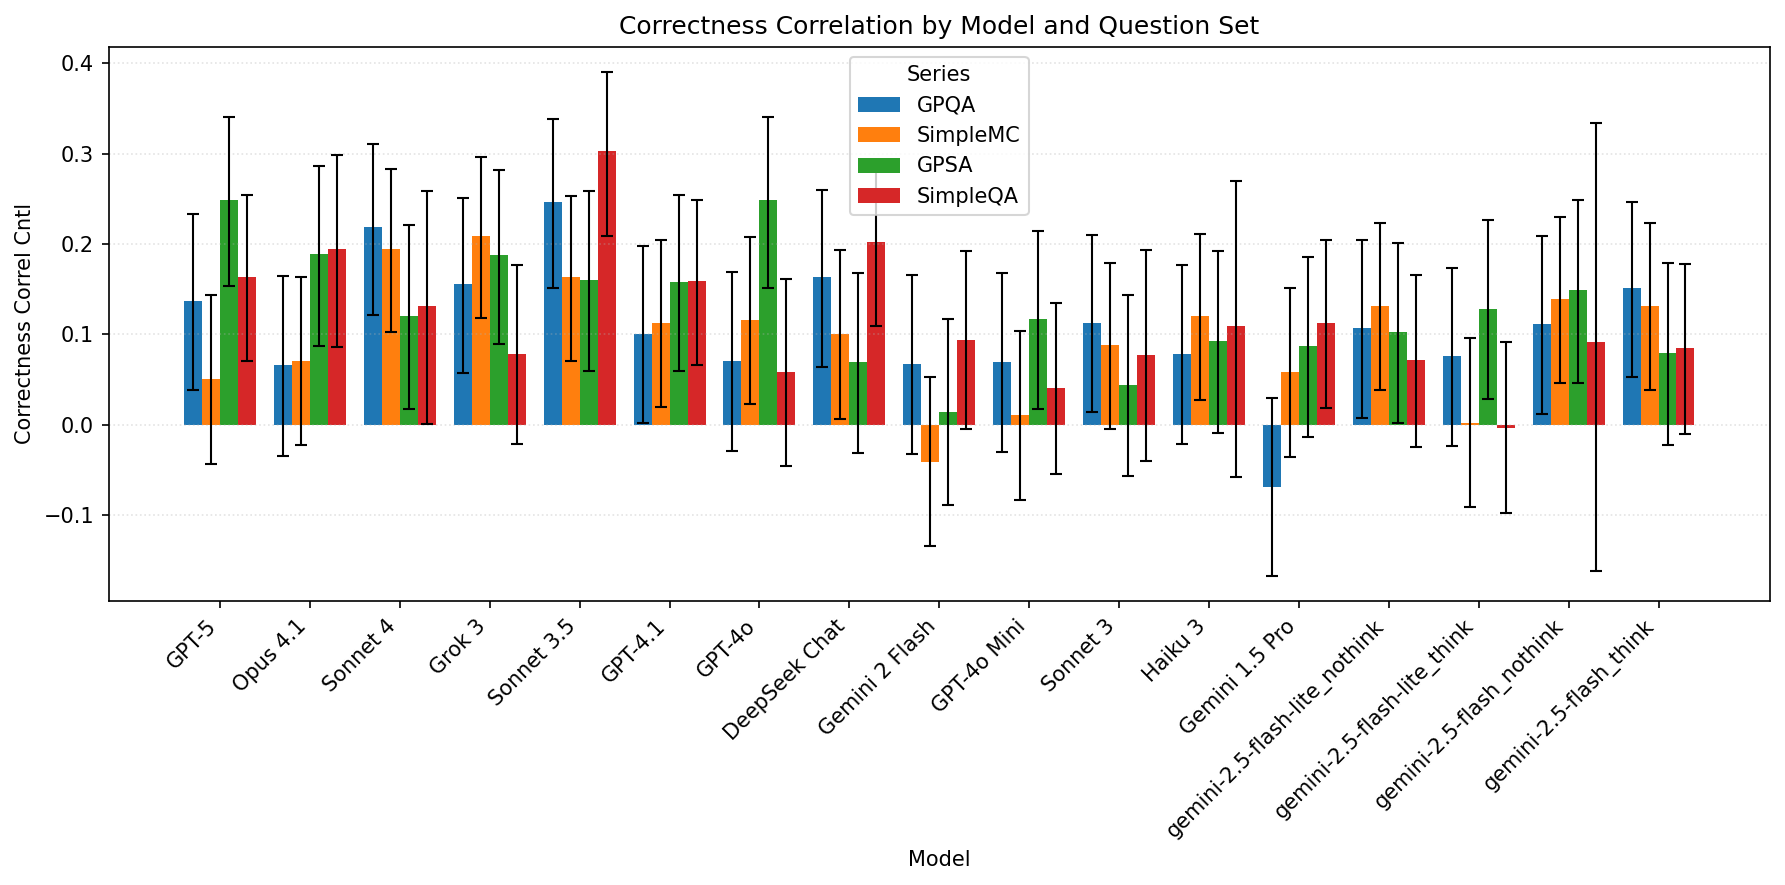

In [216]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]

metrics = [
    "Delegation rate",
    "Naive Confidence",
    "Teammate-weighted confidence",
    "Raw introspection score",
    "Raw self-acc lift",
    "Correctness Coef Cntl",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
    "Calibration Entropy AUC",
    "ECE",
    "Brier",
    "Brier Resolution",
    "Brier Reliability",
    "Top Prob Mean",
]
chance = None#0.5
model_order=["openai-gpt-5-chat", "claude-opus-4-1-20250805", 'claude-sonnet-4-20250514', 'grok-3-latest', 'claude-3-5-sonnet-20241022', 'gpt-4.1-2025-04-14', 'gpt-4o-2024-08-06', 'deepseek-chat', "gemini-2.5-flash", 'gemini-2.0-flash-001', "gemini-2.5-flash-lite", 'gpt-4o-mini', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307', 'gemini-1.5-pro']

model_aliases = {
    "openai-gpt-5-chat": "GPT-5",
    "claude-opus-4-1-20250805": "Opus 4.1",
    'claude-sonnet-4-20250514': "Sonnet 4",
    'grok-3-latest': "Grok 3",
    'claude-3-5-sonnet-20241022': "Sonnet 3.5",
    'gpt-4.1-2025-04-14': "GPT-4.1",
    'gpt-4o-2024-08-06': "GPT-4o",
    'deepseek-chat': "DeepSeek Chat",
    "gemini-2.5-flash": "Gemini 2.5 Flash",
    'gemini-2.0-flash-001': "Gemini 2 Flash",
    "gemini-2.5-flash-lite": "Gemini 2.5 Flash Lite",
    'gpt-4o-mini': "GPT-4o Mini",
    'claude-3-sonnet-20240229': "Sonnet 3",
    'claude-3-haiku-20240307': "Haiku 3",
    'gemini-1.5-pro': "Gemini 1.5 Pro",
}
fig, ax, df_wide = plot_metric_bars(
    metric="Correctness Correl Cntl",
    files=files,
    series_names=["GPQA", "SimpleMC", "GPSA", "SimpleQA"],
    model_order=model_order,
    aliases=model_aliases,
    title="Correctness Correlation by Model and Question Set",
    ylabel="",
    outfile="correctness_correl_by_model.png"
    , ecolor="black", alpha_err=1.0, chance=chance
)

In [230]:
import os
from typing import List, Optional, Dict, Tuple
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

# Assumes parse_results_file(path) exists in scope

def plot_metric_panels_from_results(
    metric: str,
    files: List[str],
    series_names: Optional[List[str]] = None,  # panel titles
    model_order: Optional[List[str]] = None,
    aliases: Optional[Dict[str, str]] = None,
    suptitle: Optional[str] = None,
    outfile: Optional[str] = None,
    dpi: int = 150,
    # Error bars
    show_errorbars: bool = True,
    ecolor: str = "gray",
    alpha_err: float = 1.0,
    elinewidth: float = 1.0,
    capsize: float = 3.0,
    # Panel behavior
    chance: Optional[float] = None,
    sharey: bool = True,
    consistent_models: bool = False,  # if True, only keep models present in ALL files
    bar_color: Optional[str] = None,  # uniform color for bars; None -> default cycle
    annotate: bool = True,            # write values inside bars
    value_fmt: str = "{:.2f}",        # format for values
    label_color: str = "black",
    label_fontsize: int = 5,
    metric_label=None,            # y-axis label (default: metric name)
    show_trend: bool = True,
    trend_color: str = "crimson",
    trend_style: str = "-",
    trend_width: float = 1.5,
    trend_weighted: bool = False,  # weight by 1/SE^2 if error bars available
    trend_text_loc: tuple = (0.04, 0.96),  # axes fraction (x,y)
    ) -> Tuple[plt.Figure, np.ndarray, List[pd.DataFrame]]:
    """
    Plot each results file in its own panel (2 files -> 1x2, 4 files -> 2x2).
    Uses parse_results_file exactly as-is.
    Returns (fig, axes_flat, list_of_value_dfs).
    """
    n = len(files)
    if n not in (1, 2, 4):
        raise ValueError("This helper expects 1, 2, or 4 files.")
    if series_names is None:
        #series_names = [os.path.basename(f) for f in files]
        def _title_of(x, i):
            if isinstance(x, str):
                return os.path.basename(x)
            return f"Panel {i+1}"  # or "Pooled"
        series_names = [_title_of(x, i) for i, x in enumerate(files)]

    if len(series_names) != n:
        raise ValueError("series_names length must match files length")

    # Parse all files
    #parsed = [parse_results_file(f) for f in files]
    # Parse all files or accept parsed dicts directly
    parsed = []
    for item in files:
        if isinstance(item, str):
            parsed.append(parse_results_file(item))
        elif isinstance(item, Mapping):
            parsed.append(item)  # already in {model: {metric: {'value','lo','hi'}}} shape
        else:
            raise TypeError("files entries must be paths (str) or parsed dicts")
    
    # Collect model sets
    model_sets = [set(d.keys()) for d in parsed]
    if model_order:
        base_models = [m for m in model_order if all((not consistent_models) or (m in s) for s in model_sets)]
        if not consistent_models:
            # include additional models from any file (but model_order first)
            union_rest = sorted(set().union(*model_sets) - set(base_models))
            base_models = base_models + union_rest
    else:
        base_models = sorted(set.intersection(*model_sets)) if consistent_models else sorted(set().union(*model_sets))

    # Layout
    if n == 1:
        nrows, ncols = 1, 1
        figsize = (7, 4.8)
    elif n == 2:
        nrows, ncols = 1, 2
        figsize = (12, 4.8)
    else:  # n == 4
        nrows, ncols = 2, 2
        figsize = (12, 9)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi, sharey=sharey)
    axes = np.array(axes).reshape(-1)  # flatten

    wide_vals_list: List[pd.DataFrame] = []
    all_ylim_candidates = []

    # Helper: find metric entry with case-insensitive fallback
    def get_entry(mm: Dict[str, Dict[str, float]], name: str):
        if name in mm:
            return mm[name]
        lm = {k.lower(): k for k in mm}
        k = lm.get(name.lower())
        return mm.get(k) if k else None

    for ax, f, title, data in zip(axes, files, series_names, parsed):
        # Build per-panel table
        models_panel = []
        vals = []
        lo_list = []
        hi_list = []

        # Respect base_models ordering; skip models missing this metric
        for m in base_models:
            entry = get_entry(data.get(m, {}), metric)
            if entry is None or entry.get("value") is None:
                continue
            v = entry.get("value", np.nan)
            lo = entry.get("lo", np.nan)
            hi = entry.get("hi", np.nan)
            models_panel.append(m)
            vals.append(v)
            lo_list.append(lo)
            hi_list.append(hi)

        # If nothing to plot, leave empty panel with a note
        if not models_panel:
            ax.text(0.5, 0.5, "No data for this metric", ha="center", va="center", fontsize=10, alpha=0.7)
            ax.set_title(title)
            ax.set_xlabel("Model")
            ax.set_ylabel(metric_label or metric)
            ax.grid(axis="y", linestyle=":", alpha=0.35)
            continue

        # DataFrame for this panel (for return/debug)
        wide = pd.DataFrame(
            {"value": vals, "lo": lo_list, "hi": hi_list},
            index=models_panel,
        )
        wide_vals_list.append(wide)

        # X/ticks
        x = np.arange(len(models_panel))
        width = 0.7
        ticklabels = [aliases.get(m, m) for m in models_panel] if aliases else models_panel

        # Error bars
        kwargs = {}
        if show_errorbars:
            v = np.asarray(vals, dtype=float)
            lo = np.asarray(lo_list, dtype=float)
            hi = np.asarray(hi_list, dtype=float)
            lower = v - lo
            upper = hi - v
            invalid = np.isnan(lower) | np.isnan(upper) | (lower < 0) | (upper < 0)
            lower = np.where(invalid, np.nan, lower)
            upper = np.where(invalid, np.nan, upper)
            yerr = ma.array(np.vstack([lower, upper]), mask=np.isnan(np.vstack([lower, upper])))
            if (~yerr.mask).any():
                kwargs.update(dict(
                    yerr=yerr, capsize=capsize,
                    error_kw=dict(elinewidth=elinewidth, alpha=alpha_err, ecolor=ecolor),
                ))

            # Collect y-limit candidates (values and CIs)
            valid_min = np.nanmin(np.where(np.isnan(lo), v, lo))
            valid_max = np.nanmax(np.where(np.isnan(hi), v, hi))
            all_ylim_candidates.append(valid_min)
            all_ylim_candidates.append(valid_max)
        else:
            all_ylim_candidates.extend([np.nanmin(vals), np.nanmax(vals)])

        # Bars
        #ax.bar(x, vals, width, **kwargs)
        bar_kwargs = dict(**kwargs)
        if bar_color is not None:
            bar_kwargs["color"] = bar_color
        bars = ax.bar(x, vals, width, **bar_kwargs)
        if annotate:
            for rect, v in zip(bars, vals):
                if np.isnan(v):
                    continue
                va = "top" if v >= 0 else "bottom"
                dy = -3 if v >= 0 else 3  # points offset
                ax.annotate(
                    value_fmt.format(v),
                    xy=(rect.get_x() + rect.get_width() / 2, v),
                    xytext=(0, dy),
                    textcoords="offset points",
                    ha="center",
                    va=va,
                    fontsize=label_fontsize,
                    color=label_color,
                    clip_on=True,
                )

        # Chance line (optional)
        if chance is not None:
            ax.axhline(chance, linestyle="--", color="0.4", linewidth=1.2, zorder=0)

        if show_trend and len(vals) >= 2:
            x_arr = np.asarray(x, dtype=float)
            y_arr = np.asarray(vals, dtype=float)
            mask = np.isfinite(y_arr)
            x_fit, y_fit = x_arr[mask], y_arr[mask]
            if len(y_fit) >= 2:
                # Optional weights from CIs
                w = None
                if trend_weighted and show_errorbars:
                    lo_arr = np.asarray(lo_list, dtype=float)[mask]
                    hi_arr = np.asarray(hi_list, dtype=float)[mask]
                    # infer SE from CI if possible
                    try:
                        from scipy.stats import norm, t as tdist
                        z = float(norm.ppf(0.975))  # assumes ~95% CI
                    except Exception:
                        z = 1.96
                        tdist = None
                    se = (hi_arr - lo_arr) / (2.0 * z)
                    w = np.where(np.isfinite(se) & (se > 0), 1.0 / (se**2), np.nan)
                    if not np.isfinite(w).any():
                        w = None

                # Fit
                slope = intercept = np.nan
                pval = np.nan
                if w is None:
                    try:
                        from scipy.stats import linregress
                        lr = linregress(x_fit, y_fit)
                        slope, intercept, pval = lr.slope, lr.intercept, lr.pvalue
                    except Exception:
                        # Unweighted closed form (no p-value)
                        X = np.vstack([np.ones_like(x_fit), x_fit]).T
                        beta = np.linalg.lstsq(X, y_fit, rcond=None)[0]
                        intercept, slope = beta[0], beta[1]
                else:
                    # Weighted least squares closed form + p-value if SciPy available
                    X = np.vstack([np.ones_like(x_fit), x_fit]).T
                    W = np.diag(w)
                    XtW = X.T @ W
                    beta = np.linalg.inv(XtW @ X) @ (XtW @ y_fit)
                    intercept, slope = float(beta[0]), float(beta[1])

                    # SE of slope and p-value
                    y_hat = X @ beta
                    resid = y_fit - y_hat
                    df = max(len(y_fit) - 2, 1)
                    sigma2 = float((resid @ (W @ resid)) / (np.sum(w) - np.sum((XtW @ X).diagonal()) + 1e-12))
                    cov = np.linalg.inv(XtW @ X) * sigma2
                    se_slope = math.sqrt(max(cov[1, 1], 0.0))
                    if se_slope > 0:
                        tstat = slope / se_slope
                        try:
                            from scipy.stats import t as tdist
                            pval = 2.0 * (1.0 - tdist.cdf(abs(tstat), df))
                        except Exception:
                            pval = np.nan

                # Plot trend line
                x_line = np.array([x_arr.min(), x_arr.max()], dtype=float)
                y_line = intercept + slope * x_line
                ax.plot(x_line, y_line, color=trend_color, linestyle=trend_style, linewidth=trend_width, zorder=3)

                # Annotate slope and p
                ax.annotate(
                    f"slope={slope:.3g}" + (f", p={pval:.3g}" if np.isfinite(pval) else ""),
                    xy=trend_text_loc, xycoords="axes fraction",
                    ha="left", va="top", fontsize=9, color=trend_color,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
                )

        # Labels
        ax.set_xticks(x)
        ax.set_xticklabels(ticklabels, rotation=45, ha="right")
        ax.set_title(title)
        ###ax.set_xlabel("Model")
        ax.set_ylabel(metric_label or metric)
        ax.grid(axis="y", linestyle=":", alpha=0.35)

    # Match y-limits across panels if sharing or if chance line suggests it
    if sharey and len(all_ylim_candidates) > 0:
        ymin = np.nanmin(all_ylim_candidates)
        ymax = np.nanmax(all_ylim_candidates)
        if chance is not None:
            ymin = np.nanmin([ymin, chance])
            ymax = np.nanmax([ymax, chance])
        if np.isfinite(ymin) and np.isfinite(ymax) and ymin != ymax:
            # Add small margin
            pad = 0.04 * (ymax - ymin)
            for ax in axes:
                ax.set_ylim(ymin - pad, ymax + pad)

    if suptitle:
        fig.suptitle(suptitle, y=0.98)
    # Show y-label only on first chart of each row
    for i, ax in enumerate(axes):
        col = i % ncols
        if col != 0:
            ax.set_ylabel("")
            ax.tick_params(axis="y", labelleft=False)  # or: left=False, labelleft=False to hide ticks too
        fig.tight_layout(rect=(0, 0, 1, 0.97))

    if outfile is None:
        safe_metric = "".join(ch if ch.isalnum() or ch in ("_", "-") else "_" for ch in metric)
        outfile = f"{safe_metric}_panels.png"
    fig.savefig(outfile, bbox_inches="tight")
    plt.show()

    return fig, axes, wide_vals_list




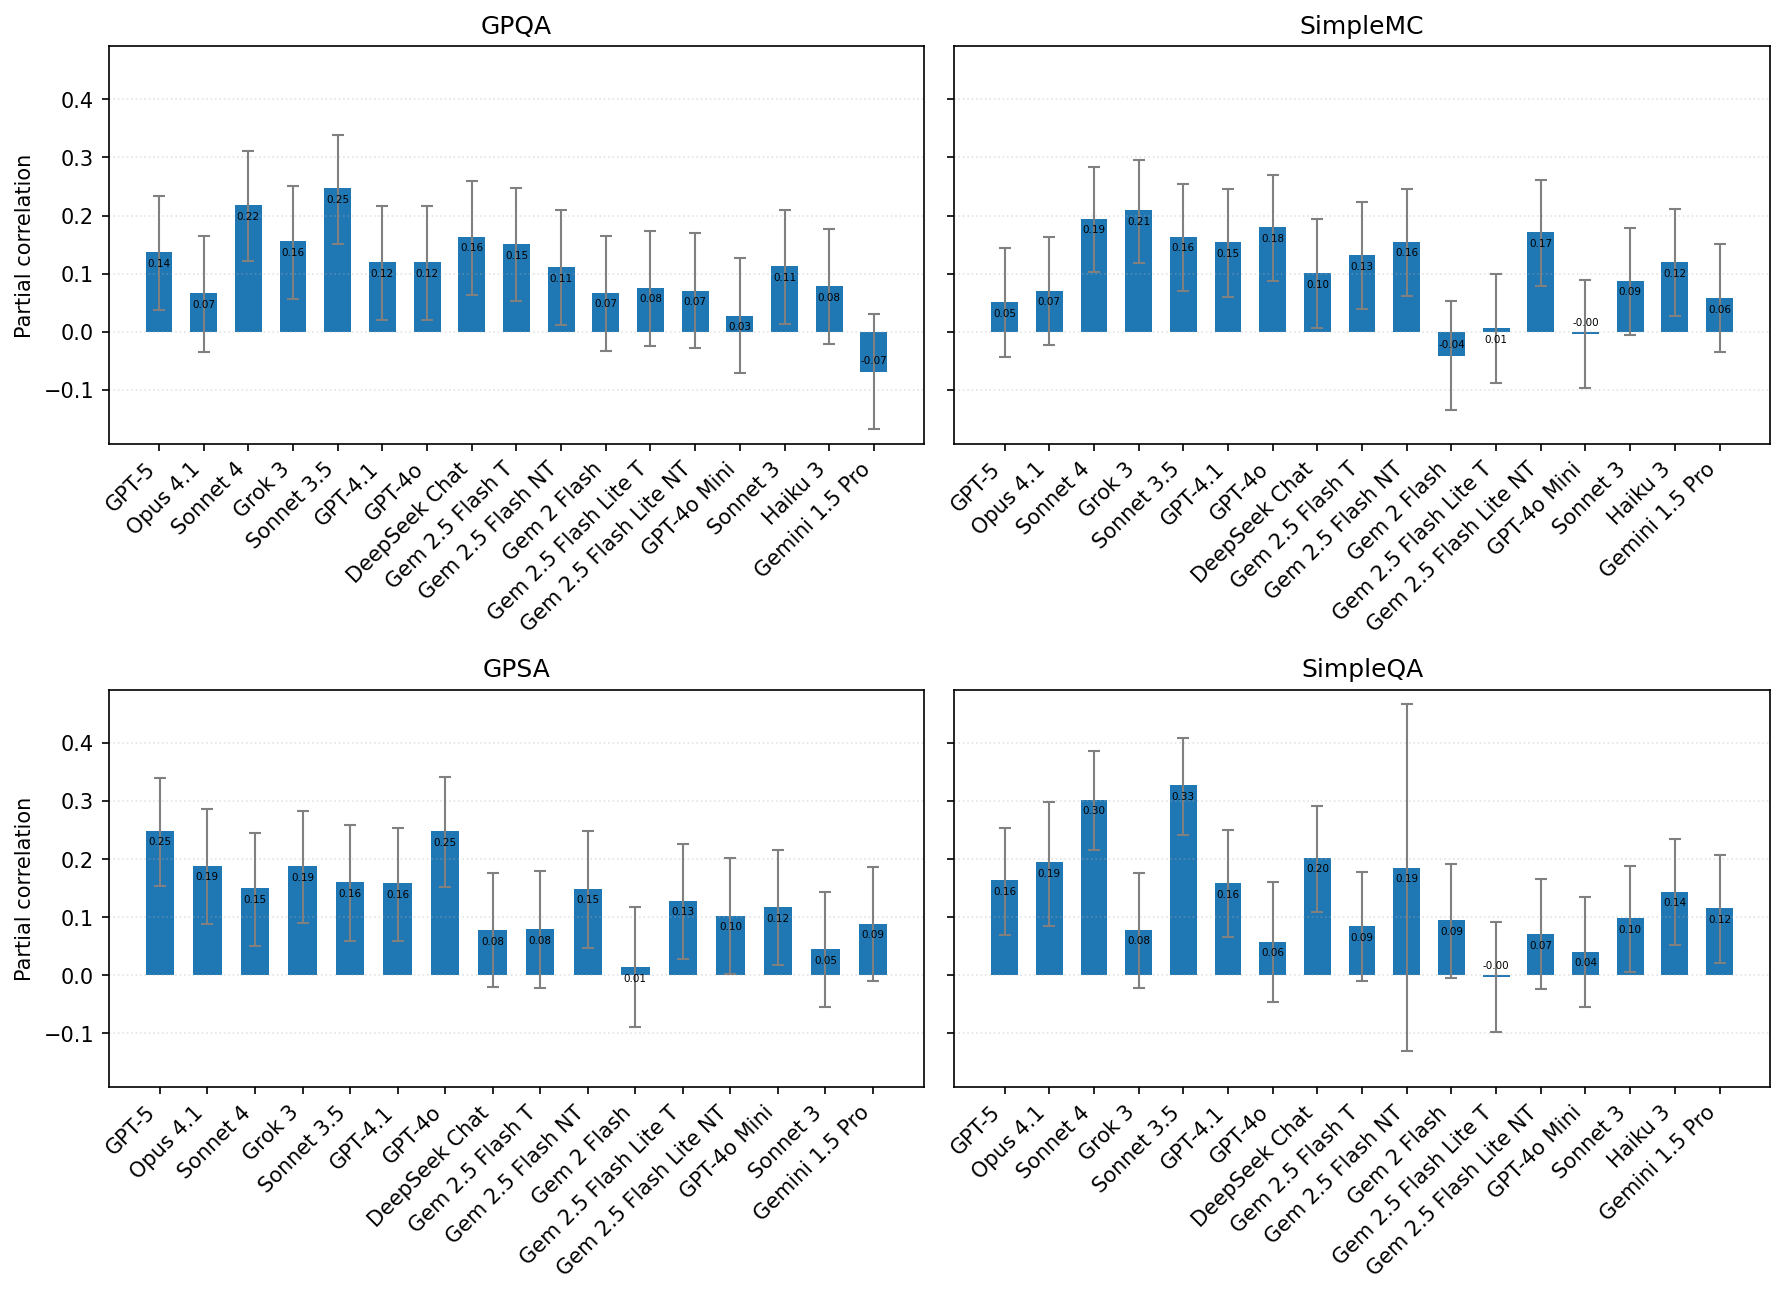

In [ ]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]
metrics = [
    "Delegation rate",
    "Naive Confidence",
    "Teammate-weighted confidence",
    "Raw introspection score",
    "Raw self-acc lift",
    "Correctness Coef Cntl",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
    "Calibration Entropy AUC",
    "ECE",
    "Brier",
    "Brier Resolution",
    "Brier Reliability",
    "Top Prob Mean",
    "Game-Stated Entropy Diff",
    "Game-Stated Confounds Diff",
]
chance = None#0.5
model_order=["openai-gpt-5-chat", "claude-opus-4-1-20250805", 'claude-sonnet-4-20250514', 'grok-3-latest', 'claude-3-5-sonnet-20241022', 'gpt-4.1-2025-04-14', 'gpt-4o-2024-08-06', 'deepseek-chat', "gemini-2.5-flash_think", "gemini-2.5-flash_nothink", 'gemini-2.0-flash-001', "gemini-2.5-flash-lite_think", "gemini-2.5-flash-lite_nothink", 'gpt-4o-mini', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307', 'gemini-1.5-pro']

model_aliases = {
    "openai-gpt-5-chat": "GPT-5",
    "claude-opus-4-1-20250805": "Opus 4.1",
    'claude-sonnet-4-20250514': "Sonnet 4",
    'grok-3-latest': "Grok 3",
    'claude-3-5-sonnet-20241022': "Sonnet 3.5",
    'gpt-4.1-2025-04-14': "GPT-4.1",
    'gpt-4o-2024-08-06': "GPT-4o",
    'deepseek-chat': "DeepSeek Chat",
    "gemini-2.5-flash_think": "Gem 2.5 Flash T",
    "gemini-2.5-flash_nothink": "Gem 2.5 Flash NT",
    'gemini-2.0-flash-001': "Gem 2 Flash",
    "gemini-2.5-flash-lite_think": "Gem 2.5 Flash Lite T",
    "gemini-2.5-flash-lite_nothink": "Gem 2.5 Flash Lite NT",
    'gpt-4o-mini': "GPT-4o Mini",
    'claude-3-sonnet-20240229': "Sonnet 3",
    'claude-3-haiku-20240307': "Haiku 3",
    'gemini-1.5-pro': "Gemini 1.5 Pro",
}
fig, ax, df_wide = plot_metric_panels_from_results(
    metric="Correctness Correl Cntl",
    files=files,
    series_names=["GPQA", "SimpleMC", "GPSA", "SimpleQA"],
    model_order=model_order,
    aliases=model_aliases,
    suptitle="",#"Partial correlation between baseline correctness and answer/delegate decision",
    outfile="is_pc_by_model.png"
    , ecolor="gray", alpha_err=1.0, chance=chance, metric_label="Partial correlation"
)



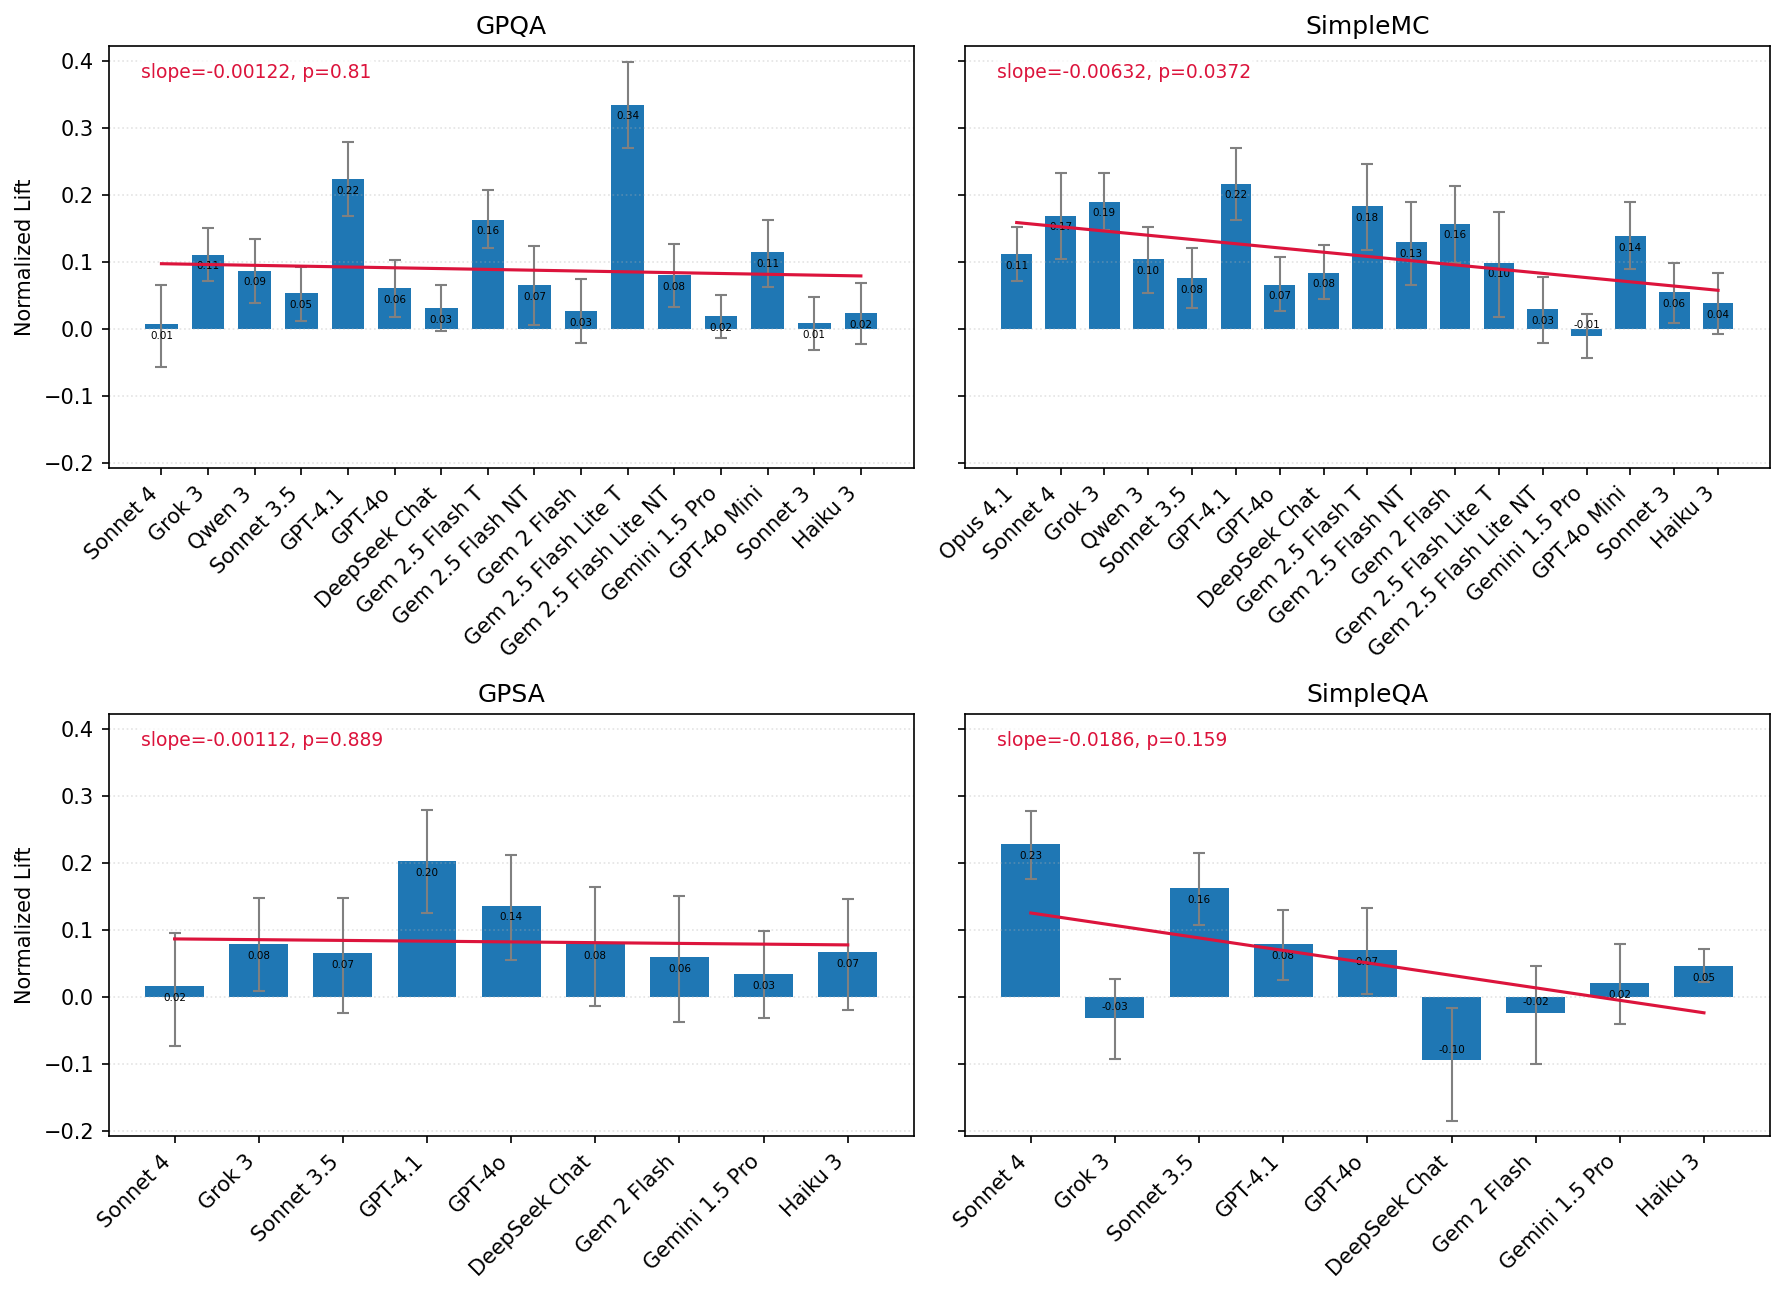

In [232]:

metrics = [
    "Mean capabilities_entropy-game_entropy",
    "Proportion of changes to 2nd choice",
    "Normalized lift",
    "Phase 2 self-accuracy",
]
model_order=["openai-gpt-5-chat", "claude-opus-4-1-20250805", 'claude-sonnet-4-20250514', 'grok-3-latest', 'qwen3-235b-a22b-2507', 'claude-3-5-sonnet-20241022', 'gpt-4.1-2025-04-14', 'gpt-4o-2024-08-06', 'deepseek-chat', "gemini-2.5-flash_think", "gemini-2.5-flash_nothink", 'gemini-2.0-flash-001', "gemini-2.5-flash-lite_think", "gemini-2.5-flash-lite_nothink", 'gemini-1.5-pro', 'gpt-4o-mini', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307']

model_aliases = {
    "openai-gpt-5-chat": "GPT-5",
    "claude-opus-4-1-20250805": "Opus 4.1",
    'claude-sonnet-4-20250514': "Sonnet 4",
    'grok-3-latest': "Grok 3",
    'qwen3-235b-a22b-2507': "Qwen 3",
    'claude-3-5-sonnet-20241022': "Sonnet 3.5",
    'gpt-4.1-2025-04-14': "GPT-4.1",
    'gpt-4o-2024-08-06': "GPT-4o",
    'deepseek-chat': "DeepSeek Chat",
    "gemini-2.5-flash_think": "Gem 2.5 Flash T",
    "gemini-2.5-flash_nothink": "Gem 2.5 Flash NT",
    'gemini-2.0-flash-001': "Gem 2 Flash",
    "gemini-2.5-flash-lite_think": "Gem 2.5 Flash Lite T",
    "gemini-2.5-flash-lite_nothink": "Gem 2.5 Flash Lite NT",
    'gpt-4o-mini': "GPT-4o Mini",
    'claude-3-sonnet-20240229': "Sonnet 3",
    'claude-3-haiku-20240307': "Haiku 3",
    'gemini-1.5-pro': "Gemini 1.5 Pro",
}
metric_aliases = {
    "Mean game_entropy-capabilities_entropy": ("sc_entdif", "Entropy Difference (Game-Baseline)"),
    "Proportion of changes to 2nd choice": ("sc_secondchoice", "Proportion of Changes to 2nd Choice"),
    "Normalized lift": ("sc_normlift", "Normalized Lift"),
    "Phase 2 self-accuracy": ("sc_acconincor", "Accuracy (%)"),
}
model_order=["claude-opus-4-1-20250805", "claude-sonnet-4-20250514", 'grok-3-latest', 'qwen3-235b-a22b-2507', "claude-3-5-sonnet-20241022", 'gpt-4.1-2025-04-14', 'gpt-4o-2024-08-06', 'deepseek-chat', "gemini-2.5-flash_think", "gemini-2.5-flash_nothink", 'gemini-2.0-flash-001', "gemini-2.5-flash-lite_think", "gemini-2.5-flash-lite_nothink", "gemini-1.5-pro", 'gpt-4o-mini', "claude-3-sonnet-20240229", 'claude-3-haiku-20240307']

chance = None#0.333
show_trend = True
metric = "Normalized lift"

if metric in ["Mean game_entropy-capabilities_entropy", "Proportion of changes to 2nd choice"]:
    #files = ["analysis_log_multi_logres_sc_gpqa_new_all.txt", "analysis_log_multi_logres_sc_simplemc_new_all.txt", "analysis_log_multi_logres_sc_gpsa_new_all.txt", "analysis_log_multi_logres_sc_simpleqa_new_all.txt"]
    files = ["analysis_log_multi_logres_sc_gpqa_neut_all.txt", "analysis_log_multi_logres_sc_simplemc_neut_all.txt", "analysis_log_multi_logres_sc_gpsa_neut_all.txt", "analysis_log_multi_logres_sc_simpleqa_neut_all.txt"]
elif metric == "Normalized lift": files = ["analysis_log_multi_logres_sc_gpqa_new_all_vs_neutral_parsed.txt", "analysis_log_multi_logres_sc_simplemc_new_all_vs_neutral_parsed.txt", "analysis_log_multi_logres_sc_gpsa_new_all_vs_neutral_parsed.txt", "analysis_log_multi_logres_sc_simpleqa_new_all_vs_neutral_parsed.txt"]
elif metric == "Phase 2 self-accuracy": files = ["analysis_log_multi_logres_sc_gpqa_new.txt", "analysis_log_multi_logres_sc_simplemc_new.txt", "analysis_log_multi_logres_sc_gpsa_new.txt", "analysis_log_multi_logres_sc_simpleqa_new.txt"]

pooled = None#pool_metric_ivw(metric=metric, files=files)#["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt"])
if pooled: files = [{model: {metric: stats} for model, stats in pooled.items()}]

fig, ax, df_wide = plot_metric_panels_from_results(
    metric=metric,
    files=files,
    series_names=["All Combined"] if pooled else ["GPQA", "SimpleMC", "GPSA", "SimpleQA"],#["GPQA-SimpleMC Combined"],#
    model_order=model_order,
    aliases=model_aliases,
    suptitle="",#"Partial correlation between baseline correctness and answer/delegate decision",
    outfile=f"{metric_aliases[metric][0]}{'_neut' if '_neut_' in files[0] else ''}_by_model_{'notrend' if not show_trend else ''}{'_pooled' if pooled else ''}_cln.png"
    , ecolor="gray", alpha_err=1.0, chance=chance, metric_label=metric_aliases[metric][1], show_trend=show_trend
)
